# Model calibration of MLP, CNN and ViT models

### Imports

In [1]:
import torch
from tqdm import tqdm

from matplotlib import pyplot as plt

from model_utils import get_test_data_and_model
from utils.metrics import topk_acc, AverageMeter
from utils.reliability_plot import *

### Compare distribution of confidence for correctly classified images

In [2]:
# Define a test function that evaluates test accuracy
@torch.no_grad()
def test(model, loader, model_name=None):
    total_acc, total_top5 = AverageMeter(), AverageMeter()
    all_conf, true_label_conv, true_label_corr_conf = [], [], []

    model.eval()

    for ims, targs in tqdm(loader, desc="Evaluation"):
        preds = model(ims)
        acc, top5 = topk_acc(preds, targs, k=5, avg=True)
        total_acc.update(acc, ims.shape[0])
        total_top5.update(top5, ims.shape[0])

        p = torch.nn.functional.softmax(preds, dim = 1)
        true_label_p = p[range(ims.shape[0]), targs]
        pred_labels = preds.argmax(dim=1)
        true_label_corr_p = true_label_p[pred_labels == targs]

        all_conf.append(p.flatten().cpu().numpy())
        true_label_conv.append(true_label_p.flatten().cpu().numpy())
        true_label_corr_conf.append(true_label_corr_p.flatten().cpu().numpy())

    return (
        total_acc.get_avg(percentage=True),
        total_top5.get_avg(percentage=True),
        all_conf,
        true_label_conv,
        true_label_corr_conf,
    )

In [4]:
dataset_name = 'cifar10'
model_name = 'mlp'

data_loader, model = get_test_data_and_model(dataset=dataset_name, model=model_name, data_path='/scratch/data/ffcv/')
test_acc, test_top5, all_conf, true_label_conv, true_label_corr_conf = test(model, data_loader, model_name)

# Print all the stats
print("Test Accuracy        ", "{:.4f}".format(test_acc))
print("Top 5 Test Accuracy          ", "{:.4f}".format(test_top5))

Weights already downloaded
Load_state output <All keys matched successfully>
Loading /scratch/data/ffcv/cifar10/val_32.beton


Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]/home/apouget/miniconda3/envs/ffcv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Evaluation: 100%|██████████| 10/10 [01:01<00:00,  6.13s/it]

Test Accuracy         94.0900
Top 5 Test Accuracy           99.6000


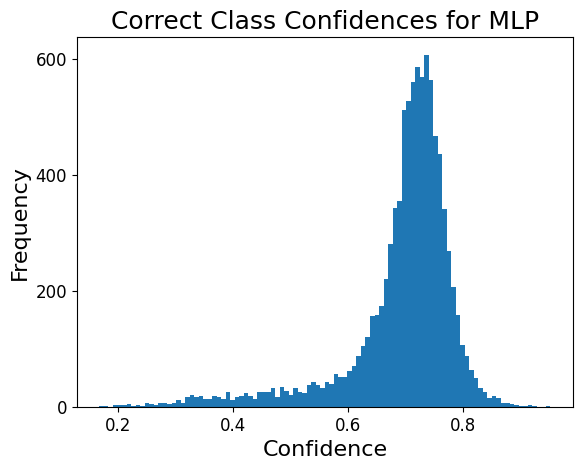

In [8]:
def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

plt.hist(flatten_comprehension(true_label_corr_conf), bins=100)
plt.title('Correct Class Confidences for MLP', fontsize=18)
plt.xlabel('Confidence', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Reliability Plots

In [9]:
dataset_name = 'cifar10'
model_name = 'mlp'

dataloader, model = get_test_data_and_model(dataset=dataset_name, model=model_name, data_path='/scratch/data/ffcv/')

def reliability_diagram(model, dataloader):
    model.eval()
    conf = torch.tensor([])
    pred = torch.tensor([])
    targ = torch.tensor([])

    with torch.no_grad():
        for ims, targs in tqdm(dataloader, desc="Evaluation"):
            preds = model(ims)
            p = torch.nn.functional.softmax(preds, dim = 1)
            correct_class_confidences = p[range(ims.shape[0]), targs]
            pred_labels = preds.argmax(dim=1)
            conf = torch.cat((conf, correct_class_confidences))
            pred = torch.cat((pred, pred_labels))
            targ = torch.cat((targ, targs))

    reliability_plot(conf, pred, targ)

reliability_diagram(model, dataloader)

Weights already downloaded
Load_state output <All keys matched successfully>
Loading /scratch/data/ffcv/cifar10/val_32.beton


Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]/home/apouget/miniconda3/envs/ffcv/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
